In [1]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import imageio
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data.dataset import random_split
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib.colors import TwoSlopeNorm

In [2]:
def process_elevation_data(file_id):
    """
    Processes elevation data from a DEM file.

    Args:
    file_id (str): Identifier of the DEM file to be processed.

    Returns:
    torch.Tensor: A tensor combining the original elevation data and its slope in x and y directions.
    """

    # Construct the file path from the given file identifier
    file_path = f'DEM_{file_id}.txt'

    # Load the elevation data from the file
    elevation_data = np.loadtxt(file_path)

    # Reshape the elevation data into a 64x64 grid
    elevation_grid = elevation_data[:, 2].reshape(64, 64)

    # Convert the elevation grid to a PyTorch tensor
    elevation_tensor = torch.tensor(elevation_grid)

    # Compute the slope in the x and y directions
    slope_x, slope_y = torch.gradient(elevation_tensor)

    # Combine the elevation tensor with the slope tensors
    elevation_slope_tensor = torch.stack((elevation_tensor, slope_x, slope_y), dim=0)

    return elevation_slope_tensor

In [3]:
def process_water_depth(file_id, time_step=0):
    """
    Processes water depth data from a specific time step in a file.

    Args:
    file_id (str): Identifier of the water depth file to be processed.
    time_step (int): Time step to extract from the file. Default is the first time step. Default is the first time step.

    Returns:
    torch.Tensor or None: A 64x64 tensor representing water depth at the given time step, or None if the data is invalid.
    """
    file_path = f'WD_{file_id}.txt'

    # Read the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    try:
        # Extract the specified row and convert string elements to floats
        selected_row = lines[time_step].split()
        depth_values = [float(val) for val in selected_row]

        # Validate and reshape the data into a 64x64 tensor
        if len(depth_values) == 64 * 64:
            depth_tensor = torch.tensor(depth_values).view(64, 64)
            return depth_tensor
        else:
            raise ValueError(f"The number of elements in {file_path} at time step {time_step} doesn't match a 64x64 matrix.")
    except IndexError:
        raise IndexError(f"Time step {time_step} is out of range for the file {file_path}.")


In [4]:
def plot_dataset_tensors(tensors, file_number, titles):
    """
    Plots a series of data tensors.

    Args:
    tensors (list of torch.Tensor): List of tensors to be plotted.
    file_number (str): Identifier of the file corresponding to the data.
    titles (list of str): Titles for each subplot corresponding to the tensors.
    """
    num_tensors = len(tensors)
    fig, axes = plt.subplots(1, num_tensors, figsize=(12, 5))

    # Adjust for a single tensor case
    if num_tensors == 1:
        axes = [axes]

    for ax, tensor, title in zip(axes, tensors, titles):
        cmap = 'terrain' if title.startswith('Elevation') else 'coolwarm'
        im = ax.imshow(tensor, cmap=cmap, origin='lower')
        fig.colorbar(im, ax=ax)
        ax.set_title(title)

    plt.suptitle(f'Training Dataset Number {file_number}', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Plot an example of training dataset

Each example corresponds to one full flood simulation, carried out assuming a dike breach flood with constant discharge of $50m^3/s$, starting in the bottom-left corner of the domain.
The domain is a 64x64 grid where each tile/patch is $100m$ in length.

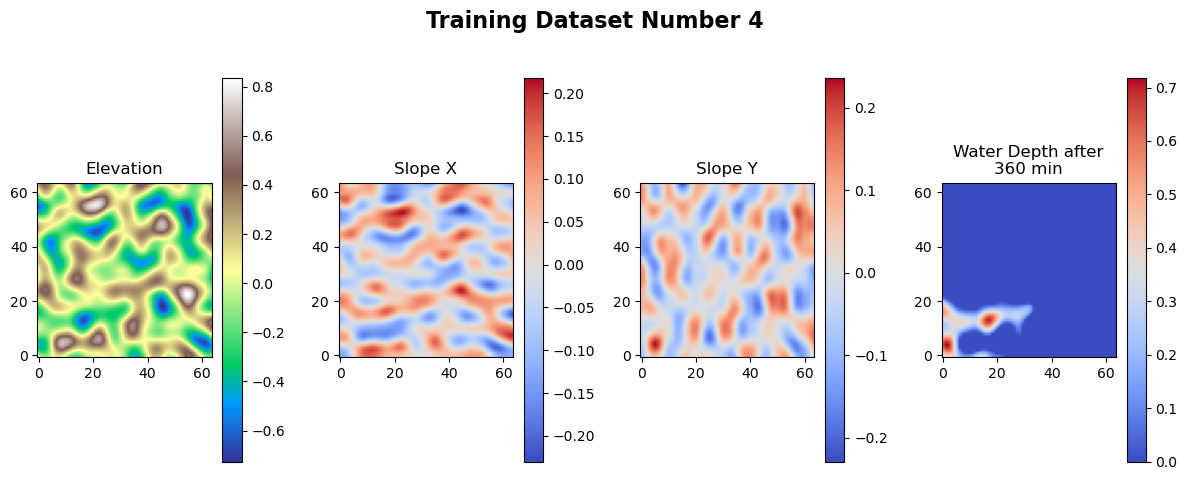

In [5]:
file_id = 4
WD_time_step = 12
elevation_slope_tensor = process_elevation_data(file_id)
water_depth_tensor = process_water_depth(file_id, time_step=WD_time_step)
combined_tensors = list(elevation_slope_tensor) + [water_depth_tensor]

# Splitting the title into two lines
water_depth_title = f'Water Depth after\n{WD_time_step*30} min'

titles = ['Elevation', 'Slope X', 'Slope Y', water_depth_title]

# Plot the data
plot_dataset_tensors(combined_tensors, file_id, titles)
# plt.savefig(r'C:\Users\carlo\Desktop\TU Delft\DSAIE\Flood_Project\Inputs_Training', dpi=500, bbox_inches='tight')

## Create a movie for one example of Training Dataset

In [ ]:
# Specify the directory where you want to save the files
output_dir = r'C:\Users\carlo\Desktop\TU Delft\DSAIE\Flood_Project\WD_Training_Dataset_Movie'

file_number = 4
num_time_steps = 50  # Adjust this according to your number of time steps

filenames = []

for WD_time_step in range(num_time_steps):
    # Process data for each time step
    elevation_slope_tensor = process_elevation_data(file_id)
    water_depth_tensor = process_water_depth(file_id, time_step=WD_time_step)
    combined_tensors = list(elevation_slope_tensor) + [water_depth_tensor]

    # Update title
    water_depth_title = f'Water Depth after\n{WD_time_step*30} min'
    titles = ['Elevation', 'Slope X', 'Slope Y', water_depth_title]

    # Plot the data
    plot_dataset_tensors(combined_tensors, file_id, titles)

    # Save each plot as an image in the specified directory
    filename = f'frame_{WD_time_step:03d}.png'
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=500, bbox_inches='tight')
    filenames.append(filepath)

In [ ]:
def resize_image(image, target_shape):
    """
    Resize the image to the target shape using PIL.
    """
    image_pil = Image.fromarray(image)
    resized_image = image_pil.resize((target_shape[1], target_shape[0]), Image.ANTIALIAS)
    return np.array(resized_image)

movie_path = os.path.join(output_dir, 'WD_Training_Dataset_Movie.mp4')
first_image = imageio.imread(filenames[1])
image_shape = first_image.shape

with imageio.get_writer(movie_path, fps=3) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        if image.shape != image_shape:
            print(f"Resizing image {filename} from {image.shape} to {image_shape}")
            image = resize_image(image, image_shape)
        writer.append_data(image)

# Optionally, remove the individual image files after creating the movie
# for filename in filenames:
#     os.remove(filename)


## Creating the Training Dataset

The training dataset is a list in which each element is a tuple with an input tensor and output tensor.

Inputs:
- digital elevation model (DEM)
- slope in the x direction
- slope in the y direction
- water depth at a specific time step t<sub>0</sub>

Outputs
- water depth at a specific time step t<sub>0</sub>+t

In [7]:
# Specify the time t0 and t

t0 = 10
t = 50

# Loop through file IDs from DEM_1 to DEM_80

train_dataset = []

for i in range(1, 81):  # Assuming file IDs are numbered from 1 to 80
    file_id = i
    
    # Input Tensor (input_tensor.shape will be [4, 64, 64])
    
    elevation_slope_tensor = process_elevation_data(file_id)
    water_depth_input_tensor = process_water_depth(file_id, time_step=t0) # Time Step is t0
    # Add an extra dimension to make water_depth_tensor [1, 64, 64]
    water_depth_input_tensor = torch.unsqueeze(water_depth_input_tensor, 0)
    
    # elevation_slope_tensor.shape --> [3, 64, 64]
    # water_depth_tensor.shape --> [1,64, 64]

    # Concatenate to create the input tensor
    input_tensor = torch.cat((elevation_slope_tensor, water_depth_input_tensor), dim=0)
    input_tensor = input_tensor.double()
    
    # Output Tensor (output_tensor.shape will be [1, 64, 64])
    water_depth_output_tensor = process_water_depth(file_id, time_step=t0+t) # Time Step is now t0+t
    # Add an extra dimension to make water_depth_tensor [1, 64, 64]
    output_tensor = torch.unsqueeze(water_depth_output_tensor, 0)
    output_tensor = output_tensor.double()
    
    # Create a tuple
    train_dataset_sample = (input_tensor, output_tensor)
    
    # Append the sample to the train_dataset list
    train_dataset.append(train_dataset_sample)

## Creating the Test Dataset


In [8]:
# Specify the time t0 and t

t0 = 10
t = 50

# Loop through file IDs from DEM_500 to DEM_519

test_dataset = []

for i in range(500, 520):  # Assuming file IDs are numbered from 1 to 80
    file_id = i
    
    # Input Tensor (input_tensor.shape will be [4, 64, 64])
    
    elevation_slope_tensor = process_elevation_data(file_id)
    water_depth_input_tensor = process_water_depth(file_id, time_step=t0) # Time Step is t0
    # Add an extra dimension to make water_depth_tensor [1, 64, 64]
    water_depth_input_tensor = torch.unsqueeze(water_depth_input_tensor, 0)
    
    # elevation_slope_tensor.shape --> [3, 64, 64]
    # water_depth_tensor.shape --> [1,64, 64]

    # Concatenate to create the input tensor for this file ID
    input_tensor = torch.cat((elevation_slope_tensor, water_depth_input_tensor), dim=0)
    input_tensor = input_tensor.double()
    
    # Output Tensor (output_tensor.shape will be [1, 64, 64])
    water_depth_output_tensor = process_water_depth(file_id, time_step=t0+t) # Time Step is now t0+t
    # Add an extra dimension to make water_depth_tensor [1, 64, 64]
    output_tensor = torch.unsqueeze(water_depth_output_tensor, 0)
    output_tensor = output_tensor.double()
    
    # Create a tuple
    test_dataset_sample = (input_tensor, output_tensor)
    
    # Append the sample to the train_dataset list
    test_dataset.append(test_dataset_sample)

## Normalization


In [9]:
def normalize_dataset(dataset, scaler_x, scaler_y):
    min_x, max_x = scaler_x.data_min_[0], scaler_x.data_max_[0]
    min_y, max_y = scaler_y.data_min_[0], scaler_y.data_max_[0]
    normalized_dataset = []
    for idx in range(len(dataset)):
        x = dataset[idx][0]
        y = dataset[idx][1]
        norm_x = (x - min_x) / (max_x - min_x)
        norm_y = (y - min_y) / (max_y - min_y)
        normalized_dataset.append((norm_x, norm_y))
    return normalized_dataset

In [10]:
# Normalize the inputs and outputs using training dataset

inputs, outputs = train_dataset[0]

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

for idx in range(len(train_dataset)):
    scaler_x.partial_fit(train_dataset[idx][0].reshape(inputs.shape[0], -1).T.cpu())
    scaler_y.partial_fit(train_dataset[idx][1].reshape(-1, 1).cpu())

normalized_train_dataset = normalize_dataset(train_dataset, scaler_x, scaler_y)
normalized_test_dataset = normalize_dataset(test_dataset, scaler_x, scaler_y)

## Split dataset into train, validation, and testing

In [11]:
train_percnt = 0.8
train_size = int(train_percnt * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(normalized_train_dataset, [train_size, val_size])

## Model

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create you own CNN model

# Define the CNN architecture

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels=1, out_channels=1, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=4, n_classes=1, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 8))
        self.down1 = (Down(8, 16))
        self.down2 = (Down(16, 32))
        self.down3 = (Down(32, 64))
        factor = 2 if bilinear else 1
        self.down4 = (Down(64, 128 // factor))
        self.up1 = (Up(128, 64 // factor, bilinear))
        self.up2 = (Up(64, 32 // factor, bilinear))
        self.up3 = (Up(32, 16 // factor, bilinear))
        self.up4 = (Up(16, 8, bilinear))
        self.outc = (OutConv(8, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# Instantiate the CNN
model = UNet().to(device)  # Replace with your model and number of classes
summary(model, input_size=(4, 64, 64))  # Replace with your input size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 64, 64]             288
       BatchNorm2d-2            [-1, 8, 64, 64]              16
              ReLU-3            [-1, 8, 64, 64]               0
            Conv2d-4            [-1, 8, 64, 64]             576
       BatchNorm2d-5            [-1, 8, 64, 64]              16
              ReLU-6            [-1, 8, 64, 64]               0
        DoubleConv-7            [-1, 8, 64, 64]               0
         MaxPool2d-8            [-1, 8, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]           1,152
      BatchNorm2d-10           [-1, 16, 32, 32]              32
             ReLU-11           [-1, 16, 32, 32]               0
           Conv2d-12           [-1, 16, 32, 32]           2,304
      BatchNorm2d-13           [-1, 16, 32, 32]              32
             ReLU-14           [-1, 16,

## Training

In [13]:
def train_epoch(model, loader, optimizer, device='cpu'):
    model.to(device)
    model.train() # specifies that the model is in training mode

    losses = []

    for batch in loader:
        x = batch[0]
        y = batch[1]
        x, y = x.float().to(device), y.float().to(device)

        # Model prediction
        preds = model(x)

        # MSE loss function
        loss = nn.MSELoss()(preds, y)

        losses.append(loss.cpu().detach())

        # Backpropagate and update weights
        loss.backward()   # compute the gradients using backpropagation
        optimizer.step()  # update the weights with the optimizer
        optimizer.zero_grad(set_to_none=True)   # reset the computed gradients

    losses = np.array(losses).mean()

    return losses

In [14]:
def evaluation(model, loader, device='cpu'):
    model.to(device)
    model.eval() # specifies that the model is in evaluation mode

    losses = []

    with torch.no_grad():
        for batch in loader:
            x = batch[0]
            y = batch[1]
            x, y = x.float().to(device), y.float().to(device)

            # Model prediction
            preds = model(x)

            # MSE loss function
            loss = nn.MSELoss()(preds, y)
            losses.append(loss.cpu().detach())

    losses = np.array(losses).mean()

    return losses

In [23]:
# Set training parameters
learning_rate = 0.001
batch_size = 64
num_epochs = 100

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(normalized_test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
train_losses = []
validation_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training loop
    train_loss = train_epoch(model, train_loader, optimizer, device=device)
    train_losses.append(train_loss)

    # Validation loop
    validation_loss = evaluation(model, val_loader, device=device)
    validation_losses.append(validation_loss)

    print(f'Epoch {epoch+1}', f'Train Loss: {train_losses}', f'Validation Loss: {validation_losses}')

Epoch 1 Train Loss: [0.027321583] Validation Loss: [0.062372223]
Epoch 2 Train Loss: [0.027321583, 0.019485341] Validation Loss: [0.062372223, 0.055571273]
Epoch 3 Train Loss: [0.027321583, 0.019485341, 0.0163793] Validation Loss: [0.062372223, 0.055571273, 0.04963878]
Epoch 4 Train Loss: [0.027321583, 0.019485341, 0.0163793, 0.013793667] Validation Loss: [0.062372223, 0.055571273, 0.04963878, 0.044306803]
Epoch 5 Train Loss: [0.027321583, 0.019485341, 0.0163793, 0.013793667, 0.012049158] Validation Loss: [0.062372223, 0.055571273, 0.04963878, 0.044306803, 0.039617956]
Epoch 6 Train Loss: [0.027321583, 0.019485341, 0.0163793, 0.013793667, 0.012049158, 0.010984237] Validation Loss: [0.062372223, 0.055571273, 0.04963878, 0.044306803, 0.039617956, 0.035672158]
Epoch 7 Train Loss: [0.027321583, 0.019485341, 0.0163793, 0.013793667, 0.012049158, 0.010984237, 0.010106229] Validation Loss: [0.062372223, 0.055571273, 0.04963878, 0.044306803, 0.039617956, 0.035672158, 0.032102324]
Epoch 8 Train 

Epoch 25 Train Loss: [0.027321583, 0.019485341, 0.0163793, 0.013793667, 0.012049158, 0.010984237, 0.010106229, 0.009304398, 0.008591217, 0.007974927, 0.0074534714, 0.0070257965, 0.0066809296, 0.006380676, 0.0060925335, 0.0058221603, 0.00558266, 0.005385935, 0.0052205827, 0.005052124, 0.0048959064, 0.0047434373, 0.0045938254, 0.0044659628, 0.0043264176] Validation Loss: [0.062372223, 0.055571273, 0.04963878, 0.044306803, 0.039617956, 0.035672158, 0.032102324, 0.028838731, 0.025898308, 0.023337469, 0.021139912, 0.019280575, 0.017701285, 0.016353201, 0.015262693, 0.014450023, 0.013881488, 0.0134216435, 0.013064545, 0.012856105, 0.01278295, 0.012801377, 0.0128641175, 0.012833351, 0.012819382]
Epoch 26 Train Loss: [0.027321583, 0.019485341, 0.0163793, 0.013793667, 0.012049158, 0.010984237, 0.010106229, 0.009304398, 0.008591217, 0.007974927, 0.0074534714, 0.0070257965, 0.0066809296, 0.006380676, 0.0060925335, 0.0058221603, 0.00558266, 0.005385935, 0.0052205827, 0.005052124, 0.0048959064, 0.0

Epoch 36 Train Loss: [0.027321583, 0.019485341, 0.0163793, 0.013793667, 0.012049158, 0.010984237, 0.010106229, 0.009304398, 0.008591217, 0.007974927, 0.0074534714, 0.0070257965, 0.0066809296, 0.006380676, 0.0060925335, 0.0058221603, 0.00558266, 0.005385935, 0.0052205827, 0.005052124, 0.0048959064, 0.0047434373, 0.0045938254, 0.0044659628, 0.0043264176, 0.0041896007, 0.004098633, 0.004017055, 0.00391147, 0.0037498712, 0.0036543799, 0.0035652565, 0.0034244717, 0.0033292996, 0.0032478315, 0.003130712] Validation Loss: [0.062372223, 0.055571273, 0.04963878, 0.044306803, 0.039617956, 0.035672158, 0.032102324, 0.028838731, 0.025898308, 0.023337469, 0.021139912, 0.019280575, 0.017701285, 0.016353201, 0.015262693, 0.014450023, 0.013881488, 0.0134216435, 0.013064545, 0.012856105, 0.01278295, 0.012801377, 0.0128641175, 0.012833351, 0.012819382, 0.012906412, 0.012718328, 0.012852611, 0.013244934, 0.013721602, 0.014042232, 0.013923639, 0.013553059, 0.013261314, 0.013342512, 0.01381352]
Epoch 37 Tr

Epoch 44 Train Loss: [0.027321583, 0.019485341, 0.0163793, 0.013793667, 0.012049158, 0.010984237, 0.010106229, 0.009304398, 0.008591217, 0.007974927, 0.0074534714, 0.0070257965, 0.0066809296, 0.006380676, 0.0060925335, 0.0058221603, 0.00558266, 0.005385935, 0.0052205827, 0.005052124, 0.0048959064, 0.0047434373, 0.0045938254, 0.0044659628, 0.0043264176, 0.0041896007, 0.004098633, 0.004017055, 0.00391147, 0.0037498712, 0.0036543799, 0.0035652565, 0.0034244717, 0.0033292996, 0.0032478315, 0.003130712, 0.0030355258, 0.0029356226, 0.0028456145, 0.002728822, 0.0026303246, 0.0025406089, 0.002572266, 0.0024600383] Validation Loss: [0.062372223, 0.055571273, 0.04963878, 0.044306803, 0.039617956, 0.035672158, 0.032102324, 0.028838731, 0.025898308, 0.023337469, 0.021139912, 0.019280575, 0.017701285, 0.016353201, 0.015262693, 0.014450023, 0.013881488, 0.0134216435, 0.013064545, 0.012856105, 0.01278295, 0.012801377, 0.0128641175, 0.012833351, 0.012819382, 0.012906412, 0.012718328, 0.012852611, 0.01

Epoch 51 Train Loss: [0.027321583, 0.019485341, 0.0163793, 0.013793667, 0.012049158, 0.010984237, 0.010106229, 0.009304398, 0.008591217, 0.007974927, 0.0074534714, 0.0070257965, 0.0066809296, 0.006380676, 0.0060925335, 0.0058221603, 0.00558266, 0.005385935, 0.0052205827, 0.005052124, 0.0048959064, 0.0047434373, 0.0045938254, 0.0044659628, 0.0043264176, 0.0041896007, 0.004098633, 0.004017055, 0.00391147, 0.0037498712, 0.0036543799, 0.0035652565, 0.0034244717, 0.0033292996, 0.0032478315, 0.003130712, 0.0030355258, 0.0029356226, 0.0028456145, 0.002728822, 0.0026303246, 0.0025406089, 0.002572266, 0.0024600383, 0.0023602422, 0.0022642026, 0.0022104993, 0.0021495335, 0.0020976467, 0.002008323, 0.0019479463] Validation Loss: [0.062372223, 0.055571273, 0.04963878, 0.044306803, 0.039617956, 0.035672158, 0.032102324, 0.028838731, 0.025898308, 0.023337469, 0.021139912, 0.019280575, 0.017701285, 0.016353201, 0.015262693, 0.014450023, 0.013881488, 0.0134216435, 0.013064545, 0.012856105, 0.01278295,

Epoch 57 Train Loss: [0.027321583, 0.019485341, 0.0163793, 0.013793667, 0.012049158, 0.010984237, 0.010106229, 0.009304398, 0.008591217, 0.007974927, 0.0074534714, 0.0070257965, 0.0066809296, 0.006380676, 0.0060925335, 0.0058221603, 0.00558266, 0.005385935, 0.0052205827, 0.005052124, 0.0048959064, 0.0047434373, 0.0045938254, 0.0044659628, 0.0043264176, 0.0041896007, 0.004098633, 0.004017055, 0.00391147, 0.0037498712, 0.0036543799, 0.0035652565, 0.0034244717, 0.0033292996, 0.0032478315, 0.003130712, 0.0030355258, 0.0029356226, 0.0028456145, 0.002728822, 0.0026303246, 0.0025406089, 0.002572266, 0.0024600383, 0.0023602422, 0.0022642026, 0.0022104993, 0.0021495335, 0.0020976467, 0.002008323, 0.0019479463, 0.0018834427, 0.0018972488, 0.002027903, 0.0017847993, 0.00185127, 0.0017135672] Validation Loss: [0.062372223, 0.055571273, 0.04963878, 0.044306803, 0.039617956, 0.035672158, 0.032102324, 0.028838731, 0.025898308, 0.023337469, 0.021139912, 0.019280575, 0.017701285, 0.016353201, 0.0152626

Epoch 63 Train Loss: [0.027321583, 0.019485341, 0.0163793, 0.013793667, 0.012049158, 0.010984237, 0.010106229, 0.009304398, 0.008591217, 0.007974927, 0.0074534714, 0.0070257965, 0.0066809296, 0.006380676, 0.0060925335, 0.0058221603, 0.00558266, 0.005385935, 0.0052205827, 0.005052124, 0.0048959064, 0.0047434373, 0.0045938254, 0.0044659628, 0.0043264176, 0.0041896007, 0.004098633, 0.004017055, 0.00391147, 0.0037498712, 0.0036543799, 0.0035652565, 0.0034244717, 0.0033292996, 0.0032478315, 0.003130712, 0.0030355258, 0.0029356226, 0.0028456145, 0.002728822, 0.0026303246, 0.0025406089, 0.002572266, 0.0024600383, 0.0023602422, 0.0022642026, 0.0022104993, 0.0021495335, 0.0020976467, 0.002008323, 0.0019479463, 0.0018834427, 0.0018972488, 0.002027903, 0.0017847993, 0.00185127, 0.0017135672, 0.0017002003, 0.0016292311, 0.0015762649, 0.0015555891, 0.0014861131, 0.0014586868] Validation Loss: [0.062372223, 0.055571273, 0.04963878, 0.044306803, 0.039617956, 0.035672158, 0.032102324, 0.028838731, 0.0

Epoch 68 Train Loss: [0.027321583, 0.019485341, 0.0163793, 0.013793667, 0.012049158, 0.010984237, 0.010106229, 0.009304398, 0.008591217, 0.007974927, 0.0074534714, 0.0070257965, 0.0066809296, 0.006380676, 0.0060925335, 0.0058221603, 0.00558266, 0.005385935, 0.0052205827, 0.005052124, 0.0048959064, 0.0047434373, 0.0045938254, 0.0044659628, 0.0043264176, 0.0041896007, 0.004098633, 0.004017055, 0.00391147, 0.0037498712, 0.0036543799, 0.0035652565, 0.0034244717, 0.0033292996, 0.0032478315, 0.003130712, 0.0030355258, 0.0029356226, 0.0028456145, 0.002728822, 0.0026303246, 0.0025406089, 0.002572266, 0.0024600383, 0.0023602422, 0.0022642026, 0.0022104993, 0.0021495335, 0.0020976467, 0.002008323, 0.0019479463, 0.0018834427, 0.0018972488, 0.002027903, 0.0017847993, 0.00185127, 0.0017135672, 0.0017002003, 0.0016292311, 0.0015762649, 0.0015555891, 0.0014861131, 0.0014586868, 0.001427505, 0.0013890757, 0.0013585172, 0.0013235846, 0.0012842786] Validation Loss: [0.062372223, 0.055571273, 0.04963878,

Epoch 73 Train Loss: [0.027321583, 0.019485341, 0.0163793, 0.013793667, 0.012049158, 0.010984237, 0.010106229, 0.009304398, 0.008591217, 0.007974927, 0.0074534714, 0.0070257965, 0.0066809296, 0.006380676, 0.0060925335, 0.0058221603, 0.00558266, 0.005385935, 0.0052205827, 0.005052124, 0.0048959064, 0.0047434373, 0.0045938254, 0.0044659628, 0.0043264176, 0.0041896007, 0.004098633, 0.004017055, 0.00391147, 0.0037498712, 0.0036543799, 0.0035652565, 0.0034244717, 0.0033292996, 0.0032478315, 0.003130712, 0.0030355258, 0.0029356226, 0.0028456145, 0.002728822, 0.0026303246, 0.0025406089, 0.002572266, 0.0024600383, 0.0023602422, 0.0022642026, 0.0022104993, 0.0021495335, 0.0020976467, 0.002008323, 0.0019479463, 0.0018834427, 0.0018972488, 0.002027903, 0.0017847993, 0.00185127, 0.0017135672, 0.0017002003, 0.0016292311, 0.0015762649, 0.0015555891, 0.0014861131, 0.0014586868, 0.001427505, 0.0013890757, 0.0013585172, 0.0013235846, 0.0012842786, 0.0012598312, 0.001231408, 0.0011988515, 0.0011834232, 

Epoch 78 Train Loss: [0.027321583, 0.019485341, 0.0163793, 0.013793667, 0.012049158, 0.010984237, 0.010106229, 0.009304398, 0.008591217, 0.007974927, 0.0074534714, 0.0070257965, 0.0066809296, 0.006380676, 0.0060925335, 0.0058221603, 0.00558266, 0.005385935, 0.0052205827, 0.005052124, 0.0048959064, 0.0047434373, 0.0045938254, 0.0044659628, 0.0043264176, 0.0041896007, 0.004098633, 0.004017055, 0.00391147, 0.0037498712, 0.0036543799, 0.0035652565, 0.0034244717, 0.0033292996, 0.0032478315, 0.003130712, 0.0030355258, 0.0029356226, 0.0028456145, 0.002728822, 0.0026303246, 0.0025406089, 0.002572266, 0.0024600383, 0.0023602422, 0.0022642026, 0.0022104993, 0.0021495335, 0.0020976467, 0.002008323, 0.0019479463, 0.0018834427, 0.0018972488, 0.002027903, 0.0017847993, 0.00185127, 0.0017135672, 0.0017002003, 0.0016292311, 0.0015762649, 0.0015555891, 0.0014861131, 0.0014586868, 0.001427505, 0.0013890757, 0.0013585172, 0.0013235846, 0.0012842786, 0.0012598312, 0.001231408, 0.0011988515, 0.0011834232, 

Epoch 82 Train Loss: [0.027321583, 0.019485341, 0.0163793, 0.013793667, 0.012049158, 0.010984237, 0.010106229, 0.009304398, 0.008591217, 0.007974927, 0.0074534714, 0.0070257965, 0.0066809296, 0.006380676, 0.0060925335, 0.0058221603, 0.00558266, 0.005385935, 0.0052205827, 0.005052124, 0.0048959064, 0.0047434373, 0.0045938254, 0.0044659628, 0.0043264176, 0.0041896007, 0.004098633, 0.004017055, 0.00391147, 0.0037498712, 0.0036543799, 0.0035652565, 0.0034244717, 0.0033292996, 0.0032478315, 0.003130712, 0.0030355258, 0.0029356226, 0.0028456145, 0.002728822, 0.0026303246, 0.0025406089, 0.002572266, 0.0024600383, 0.0023602422, 0.0022642026, 0.0022104993, 0.0021495335, 0.0020976467, 0.002008323, 0.0019479463, 0.0018834427, 0.0018972488, 0.002027903, 0.0017847993, 0.00185127, 0.0017135672, 0.0017002003, 0.0016292311, 0.0015762649, 0.0015555891, 0.0014861131, 0.0014586868, 0.001427505, 0.0013890757, 0.0013585172, 0.0013235846, 0.0012842786, 0.0012598312, 0.001231408, 0.0011988515, 0.0011834232, 

Epoch 86 Train Loss: [0.027321583, 0.019485341, 0.0163793, 0.013793667, 0.012049158, 0.010984237, 0.010106229, 0.009304398, 0.008591217, 0.007974927, 0.0074534714, 0.0070257965, 0.0066809296, 0.006380676, 0.0060925335, 0.0058221603, 0.00558266, 0.005385935, 0.0052205827, 0.005052124, 0.0048959064, 0.0047434373, 0.0045938254, 0.0044659628, 0.0043264176, 0.0041896007, 0.004098633, 0.004017055, 0.00391147, 0.0037498712, 0.0036543799, 0.0035652565, 0.0034244717, 0.0033292996, 0.0032478315, 0.003130712, 0.0030355258, 0.0029356226, 0.0028456145, 0.002728822, 0.0026303246, 0.0025406089, 0.002572266, 0.0024600383, 0.0023602422, 0.0022642026, 0.0022104993, 0.0021495335, 0.0020976467, 0.002008323, 0.0019479463, 0.0018834427, 0.0018972488, 0.002027903, 0.0017847993, 0.00185127, 0.0017135672, 0.0017002003, 0.0016292311, 0.0015762649, 0.0015555891, 0.0014861131, 0.0014586868, 0.001427505, 0.0013890757, 0.0013585172, 0.0013235846, 0.0012842786, 0.0012598312, 0.001231408, 0.0011988515, 0.0011834232, 

Epoch 90 Train Loss: [0.027321583, 0.019485341, 0.0163793, 0.013793667, 0.012049158, 0.010984237, 0.010106229, 0.009304398, 0.008591217, 0.007974927, 0.0074534714, 0.0070257965, 0.0066809296, 0.006380676, 0.0060925335, 0.0058221603, 0.00558266, 0.005385935, 0.0052205827, 0.005052124, 0.0048959064, 0.0047434373, 0.0045938254, 0.0044659628, 0.0043264176, 0.0041896007, 0.004098633, 0.004017055, 0.00391147, 0.0037498712, 0.0036543799, 0.0035652565, 0.0034244717, 0.0033292996, 0.0032478315, 0.003130712, 0.0030355258, 0.0029356226, 0.0028456145, 0.002728822, 0.0026303246, 0.0025406089, 0.002572266, 0.0024600383, 0.0023602422, 0.0022642026, 0.0022104993, 0.0021495335, 0.0020976467, 0.002008323, 0.0019479463, 0.0018834427, 0.0018972488, 0.002027903, 0.0017847993, 0.00185127, 0.0017135672, 0.0017002003, 0.0016292311, 0.0015762649, 0.0015555891, 0.0014861131, 0.0014586868, 0.001427505, 0.0013890757, 0.0013585172, 0.0013235846, 0.0012842786, 0.0012598312, 0.001231408, 0.0011988515, 0.0011834232, 

Epoch 94 Train Loss: [0.027321583, 0.019485341, 0.0163793, 0.013793667, 0.012049158, 0.010984237, 0.010106229, 0.009304398, 0.008591217, 0.007974927, 0.0074534714, 0.0070257965, 0.0066809296, 0.006380676, 0.0060925335, 0.0058221603, 0.00558266, 0.005385935, 0.0052205827, 0.005052124, 0.0048959064, 0.0047434373, 0.0045938254, 0.0044659628, 0.0043264176, 0.0041896007, 0.004098633, 0.004017055, 0.00391147, 0.0037498712, 0.0036543799, 0.0035652565, 0.0034244717, 0.0033292996, 0.0032478315, 0.003130712, 0.0030355258, 0.0029356226, 0.0028456145, 0.002728822, 0.0026303246, 0.0025406089, 0.002572266, 0.0024600383, 0.0023602422, 0.0022642026, 0.0022104993, 0.0021495335, 0.0020976467, 0.002008323, 0.0019479463, 0.0018834427, 0.0018972488, 0.002027903, 0.0017847993, 0.00185127, 0.0017135672, 0.0017002003, 0.0016292311, 0.0015762649, 0.0015555891, 0.0014861131, 0.0014586868, 0.001427505, 0.0013890757, 0.0013585172, 0.0013235846, 0.0012842786, 0.0012598312, 0.001231408, 0.0011988515, 0.0011834232, 

Epoch 98 Train Loss: [0.027321583, 0.019485341, 0.0163793, 0.013793667, 0.012049158, 0.010984237, 0.010106229, 0.009304398, 0.008591217, 0.007974927, 0.0074534714, 0.0070257965, 0.0066809296, 0.006380676, 0.0060925335, 0.0058221603, 0.00558266, 0.005385935, 0.0052205827, 0.005052124, 0.0048959064, 0.0047434373, 0.0045938254, 0.0044659628, 0.0043264176, 0.0041896007, 0.004098633, 0.004017055, 0.00391147, 0.0037498712, 0.0036543799, 0.0035652565, 0.0034244717, 0.0033292996, 0.0032478315, 0.003130712, 0.0030355258, 0.0029356226, 0.0028456145, 0.002728822, 0.0026303246, 0.0025406089, 0.002572266, 0.0024600383, 0.0023602422, 0.0022642026, 0.0022104993, 0.0021495335, 0.0020976467, 0.002008323, 0.0019479463, 0.0018834427, 0.0018972488, 0.002027903, 0.0017847993, 0.00185127, 0.0017135672, 0.0017002003, 0.0016292311, 0.0015762649, 0.0015555891, 0.0014861131, 0.0014586868, 0.001427505, 0.0013890757, 0.0013585172, 0.0013235846, 0.0012842786, 0.0012598312, 0.001231408, 0.0011988515, 0.0011834232, 

## Results

In [25]:
test_loss = evaluation(model, test_loader, device=device)
print(test_loss)

0.002919304


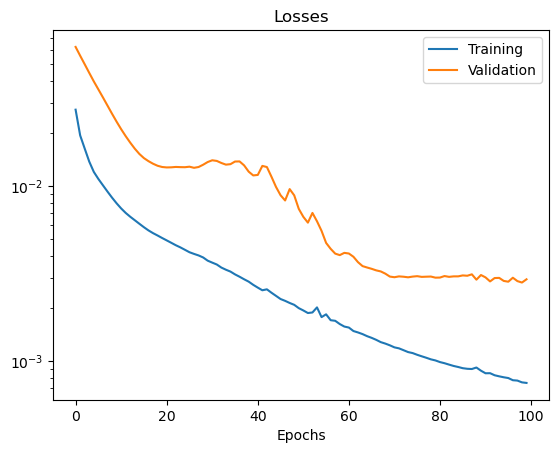

In [26]:
plt.plot(train_losses, label='Training')
plt.plot(validation_losses, label='Validation')
plt.yscale('log')
plt.title('Losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [32]:
# select one sample
data_id = 4

x = normalized_test_dataset[data_id][0].unsqueeze(0)
x = x.float().to(device)
FAT = normalized_test_dataset[data_id][1]

# predict the FAT
pred_FAT = model(x).detach()

In [33]:
DEM = scaler_x.inverse_transform(x[0].reshape(4,-1).T.cpu())[:,0].reshape(64,64)
real_FAT = scaler_y.inverse_transform(FAT.reshape(-1,1).cpu()).reshape(64,64)
pred_FAT = scaler_y.inverse_transform(pred_FAT.reshape(-1,1).cpu()).reshape(64,64)

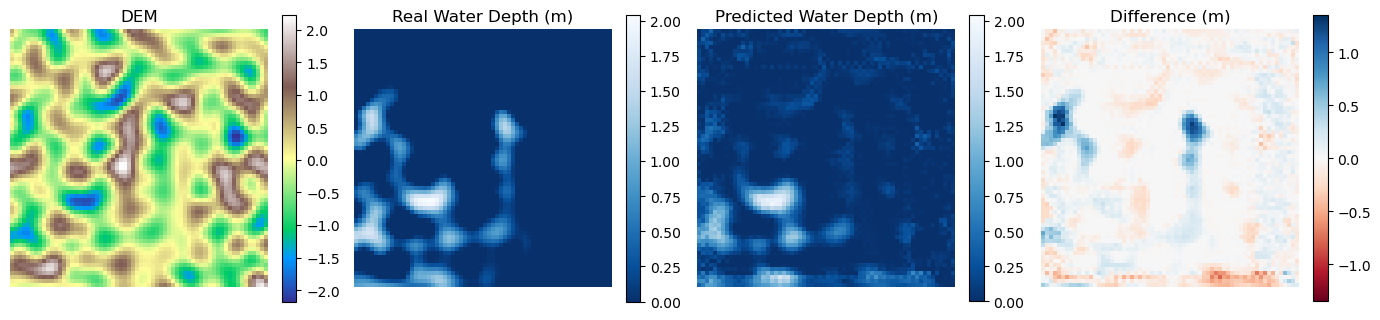

In [34]:
fig, axs = plt.subplots(1, 4, figsize=(17,5))

diff_FAT = real_FAT - pred_FAT
max_FAT = max(pred_FAT.max(), real_FAT.max())
max_diff = max(diff_FAT.max(), -diff_FAT.min())

axs[0].imshow(DEM.squeeze(), cmap='terrain', origin='lower')
axs[1].imshow(real_FAT.squeeze(), vmin = 0, vmax=max_FAT, cmap='Blues_r', origin='lower')
axs[2].imshow(pred_FAT.squeeze(), vmin = 0, vmax=max_FAT,cmap='Blues_r', origin='lower')
axs[3].imshow(diff_FAT.squeeze(), vmin=-max_diff, vmax=max_diff, cmap='RdBu', origin='lower')

plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = DEM.min(), vmax=DEM.max()),
                            cmap='terrain'), fraction=0.05, shrink=0.9, ax=axs[0])
plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = 0, vmax=max_FAT),
                            cmap='Blues_r'), fraction=0.05, shrink=0.9, ax=axs[1])
plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = 0, vmax=max_FAT),
                            cmap='Blues_r'), fraction=0.05, shrink=0.9, ax=axs[2])
plt.colorbar(plt.cm.ScalarMappable(norm=TwoSlopeNorm(vmin=-max_diff, vmax=max_diff, vcenter=0),
                            cmap='RdBu'), fraction=0.05, shrink=0.9, ax=axs[3])
for ax in axs:
    ax.axis('off')

axs[0].set_title('DEM')
axs[1].set_title('Real Water Depth (m)')
axs[2].set_title('Predicted Water Depth (m)')
axs[3].set_title('Difference (m)')

plt.show()